In [1]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import lux
import matplotlib.pyplot as plt
%matplotlib inline

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

np.set_printoptions(suppress=True) # do not print scientific notation

# Set some matplotlib style parameters
plt.style.use('seaborn')
plt.rcParams.update({'figure.facecolor': 'white',
                     'figure.edgecolor': 'white',
                     'axes.grid': True,
                     'figure.autolayout': True # tight_layout
                    })

# Set some pandas options
pd.set_option('display.max_columns', None, # show x columns (None shows all)
              # 'display.max_rows', None,  # show x rows (None shows all)
              'compute.use_numba', True)   # turn off for Lux

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
seed = 42
rng = np.random.default_rng(seed)

secure_bits = 25        # rows
corrected_key_bits = 50 # columns
N_vec = 10000           # nº of corrected key vectors

## Functions

### Detect operations

In [5]:
def Count_1times1(mat, vec):
    row_count = [0] * secure_bits
    for i in range(secure_bits):
        for j in range(corrected_key_bits):
            if mat[i, j] and vec[j]:
                row_count[i] += 1
    return row_count

In [6]:
def Count_0times1(mat, vec):
    row_count = [0] * secure_bits
    for i in range(secure_bits):
        for j in range(corrected_key_bits):
            if (not mat[i, j] and vec[j]) or \
               (mat[i, j] and not vec[j]):
                row_count[i] += 1
    return row_count

In [7]:
def Count_0times0(mat, vec):
    row_count = [0] * secure_bits
    for i in range(secure_bits):
        for j in range(corrected_key_bits):
            if not mat[i, j] and not vec[j]:
                row_count[i] += 1
    return row_count

In [8]:
# Some experiments...

# # Count all +1 (same as Count_1times1...)
# def Count_plus1(mat, vec):
#     row_count = [0] * secure_bits
#     for i in range(secure_bits):
#         for j in range(corrected_key_bits):
#             if mat[i, j] * vec[j]:
#                 row_count[i] += 1
#     return row_count

# Only count additions to initial 1 in each row (as if the first 1 was already in the memory address of the result)
def Count_plus1(mat, vec):
    row_count = [0] * secure_bits
    for i in range(secure_bits):
        count_1s = 0
        for j in range(corrected_key_bits):
            if mat[i, j] * vec[j]:
                count_1s += 1 # count 1s in each row
        if count_1s != 0:
            row_count[i] += count_1s - 1 # sum 1+1 additions per row if there are any 1s
    return row_count

# Count 1+1 sequentially in each row (works even if operations are not sequential)
    # (counting 1+0 or 0+0 gives different results if operations are not sequential,
    # but counting (1+0)+(0+0) still gives consistent results)
def Count_1plus1(mat, vec):
    row_count = [0] * secure_bits
    for i in range(secure_bits):
        result = mat[i, 0] * vec[0]
        for j in range(1, corrected_key_bits):
            next_element = mat[i, j] * vec[j]
            if result and next_element:
                row_count[i] += 1
            result = (result + next_element) % 2
    return row_count

### Class

In [9]:
# Detect if there are more 1s than 0s
def More_1_than_0(mat, vec):
    return np.sum(mat @ vec % 2) > secure_bits / 2

### Other

In [10]:
# Check if output vectors from sample are unique
def Check_uniqueness(mat, vec):
    res = []
    for i in range(len(vec)):
        res.append(mat @ vec[i] % 2)
    unique = np.unique(res, axis=0, return_counts=True)
    return unique[1].shape[0] == np.shape(vec)[0], unique[1].shape[0]

## Generate data

In [11]:
mat = rng.integers(2, size=(secure_bits,corrected_key_bits), dtype=np.int8)

mat.shape, mat

((25, 50),
 array([[1, 0, 1, ..., 1, 0, 0],
        [0, 1, 0, ..., 1, 0, 1],
        [0, 0, 1, ..., 1, 1, 1],
        ...,
        [1, 0, 0, ..., 0, 0, 1],
        [0, 1, 1, ..., 0, 1, 0],
        [1, 0, 0, ..., 1, 0, 1]], dtype=int8))

In [12]:
vec = [rng.integers(2, size=corrected_key_bits, dtype=np.int8) for _ in range(N_vec)]

np.shape(vec), vec[0]

((10000, 50),
 array([1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
        0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
        0, 1, 1, 1, 1, 0], dtype=int8))

In [11]:
print('Are solutions from this sample unique? %s ---> %i unique sols out of %i' % (*Check_uniqueness(mat, vec), N_vec))

Are solutions from this sample unique? False ---> 9999 unique sols out of 10000


In [12]:
i = 0
print('1*1:', Count_1times1(mat, vec[i]))
print('0*1:', Count_0times1(mat, vec[i]))
print('0*0:', Count_0times0(mat, vec[i]))
print(' +1:', Count_plus1(mat, vec[i]))
print('1+1:', Count_1plus1(mat, vec[i]))

1*1: [14, 15, 14, 14, 15, 10, 17, 12, 15, 20, 14, 15, 13, 13, 7, 10, 13, 12, 12, 12, 19, 11, 12, 16, 12]
0*1: [28, 23, 25, 25, 23, 30, 19, 27, 26, 18, 22, 24, 27, 24, 30, 29, 26, 29, 26, 29, 18, 29, 28, 24, 30]
0*0: [8, 12, 11, 11, 12, 10, 14, 11, 9, 12, 14, 11, 10, 13, 13, 11, 11, 9, 12, 9, 13, 10, 10, 10, 8]
 +1: [13, 14, 13, 13, 14, 9, 16, 11, 14, 19, 13, 14, 12, 12, 6, 9, 12, 11, 11, 11, 18, 10, 11, 15, 11]
1+1: [7, 7, 7, 7, 7, 5, 8, 6, 7, 10, 7, 7, 6, 6, 3, 5, 6, 6, 6, 6, 9, 5, 6, 8, 6]


In [13]:
print("#1 > #0?")
print("--------")
for i in range(10):
    print(More_1_than_0(mat, vec[i]), '\t', mat @ vec[i] % 2)

#1 > #0?
--------
False 	 [0 1 0 0 1 0 1 0 1 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 0]
True 	 [1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0]
False 	 [1 1 1 1 0 0 0 0 1 0 1 1 0 0 0 1 1 1 0 0 1 0 1 0 0]
False 	 [0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0]
False 	 [1 1 0 1 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 0]
True 	 [1 0 0 1 1 0 1 0 0 1 0 1 1 1 1 0 0 0 0 1 1 1 0 1 1]
True 	 [0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 0 0 0 0 1 1 0 0 1]
True 	 [1 1 0 1 0 1 0 1 1 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 0]
True 	 [0 1 1 0 1 1 1 0 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 1]
False 	 [1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 1 1 1 0 0 1 1 0 1 0]


In [13]:
# Warning: data is not time-ordered, i.e. row-by-row counts
data = [[*Count_1times1(mat, vec[i]),
         *Count_0times1(mat, vec[i]),
         *Count_0times0(mat, vec[i]),
         # *Count_plus1(mat, vec[i]),
         *Count_1plus1(mat, vec[i]),
         More_1_than_0(mat, vec[i])] for i in range(N_vec)]
np.shape(data)

(10000, 101)

In [14]:
# Create column labels
columns = []
for op in ['1*1', '0*1', '0*0', '1+1']:
    columns += [op + '_' + str(i) for i in range(secure_bits)]
columns += ['More_1_than_0']

# Create dataframe
df = pd.DataFrame(data, columns=columns)
df

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [16]:
# Check some trends in data (turn off numba engine first)
pd.set_option('compute.use_numba', False)
df2 = df.copy()
df2.intent = ['More_1_than_0']
display(df2)
pd.set_option('compute.use_numba', True)

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [189]:
# Generate pandas profiling report
profile = ProfileReport(df, title="More_1s_or_0s N_Ops_per_Row Dataset Report", explorative=True)
# profile.to_widgets()
profile.to_file("Docs/More_1s_or_0s_-_N_Ops_per_Row_report.html")

Summarize dataset:   0%|          | 0/114 [00:00<?, ?it/s]

C:\Users\V082335\Anaconda3\lib\site-packages\pandas\core\series.py:1441: PerformanceWarning:DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Split data

In [15]:
# Split data into training & test set
X = np.asarray(df.drop('More_1_than_0', axis=1))
y = np.asarray(df['More_1_than_0'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed) # used before cross-val

## Classifiers

Models able to to predict with ~100% accuracy:
- Logistic regression
- Linear SVM (and polynomial-kernel SVM by extension)

Models which comparatively suck:
- RBF-kernel SVM
- Sigmoid-kernel SVM
- All Naïve Bayes
- Decision tree

In [17]:
# Train model with stratified k-fold cross-validation & get statistics
def Train_stratCV(model, X, y, n_splits=5, seed=seed):
    skf = StratifiedKFold(n_splits, shuffle=True, random_state=seed)
    lst_acc = []
    lst_y_pred = [] # not used yet

    # Train & test each fold
    for train_idx, test_idx in skf.split(X, y):
        x_train_fold, x_test_fold = X[train_idx], X[test_idx]
        y_train_fold, y_test_fold = y[train_idx], y[test_idx]
        model.fit(x_train_fold, y_train_fold)
        lst_acc.append(model.score(x_test_fold, y_test_fold))
        lst_y_pred.append(model.predict(x_test_fold))

    print(f'\nList of accuracies: {lst_acc}')
    print(f'Min/max accuracy:   {min(lst_acc):.2%} <---> {max(lst_acc):.2%}')
    print(f'Mean accuracy:      {np.mean(lst_acc):.2%} +- {np.std(lst_acc):.3%}')
    
    # add more stats
    
    return lst_acc, lst_y_pred

# accuracy_score(y_test, y_pred) # how often is the classifier correct?
# confusion_matrix(y_test, y_pred, normalize='pred') # precision
# confusion_matrix(y_test, y_pred, normalize='true') # recall
# classification_report(y_test, y_pred, output_dict=True)

### Logistic regression

In [19]:
model = SGDClassifier(loss='log', learning_rate='adaptive', eta0=1e-3, max_iter=1e5, tol=1e-5, n_jobs=-1, random_state=seed,
                      verbose=-1)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

Convergence after 162 epochs took 0.64 seconds
Convergence after 173 epochs took 0.64 seconds
Convergence after 153 epochs took 0.54 seconds
Convergence after 177 epochs took 0.62 seconds
Convergence after 167 epochs took 0.60 seconds

List of accuracies: [1.0, 1.0, 0.999, 1.0, 0.9995]
Min/max accuracy:   99.90% <---> 100.00%
Mean accuracy:      99.97% +- 0.040%


In [44]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

Confusion matrix: 
 [[ 996    1]
 [   0 1003]]

Report: 
               precision    recall  f1-score   support

       False      1.000     0.999     0.999       997
        True      0.999     1.000     1.000      1003

    accuracy                          1.000      2000
   macro avg      1.000     0.999     0.999      2000
weighted avg      1.000     1.000     0.999      2000

Mean accuracy on test set: 99.95%
Mean certainty (even if wrong): 95.92%


### SVM

#### Linear kernel

In [23]:
model = SVC(kernel='linear', probability=False, random_state=seed, verbose=True)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
List of accuracies: [1.0, 1.0, 1.0, 1.0, 1.0]
Min/max accuracy:   100.00% <---> 100.00%
Mean accuracy:      100.00% +- 0.000%


In [646]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

In [94]:
model = SGDClassifier(loss='hinge', learning_rate='adaptive', eta0=1e5, tol=1e-9, n_jobs=-1, random_state=seed, verbose=-1)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

Convergence after 289 epochs took 0.65 seconds
Convergence after 161 epochs took 0.54 seconds
Convergence after 214 epochs took 0.58 seconds
Convergence after 191 epochs took 0.50 seconds
Convergence after 202 epochs took 0.57 seconds

List of accuracies: [1.0, 0.996, 0.998, 0.9955, 0.9925]
Min/max accuracy:   99.25% <---> 100.00%
Mean accuracy:      99.64% +- 0.252%


In [186]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

In [96]:
model = LinearSVC(loss='squared_hinge', dual=False, tol=1e-9, random_state=seed, verbose=1)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]
List of accuracies: [1.0, 1.0, 1.0, 1.0, 1.0]
Min/max accuracy:   100.00% <---> 100.00%
Mean accuracy:      100.00% +- 0.000%


In [188]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

#### Gaussian kernel

In [48]:
model = SVC(kernel='rbf', gamma='scale', tol=1e-5, probability=False, random_state=seed, verbose=True)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
List of accuracies: [0.5575, 0.5625, 0.565, 0.5675, 0.5775]
Min/max accuracy:   55.75% <---> 57.75%
Mean accuracy:      56.60% +- 0.663%


In [49]:
model = SVC(kernel='rbf', gamma='auto', tol=1e-5, probability=False, random_state=seed, verbose=True)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
List of accuracies: [0.511, 0.514, 0.5205, 0.5185, 0.4975]
Min/max accuracy:   49.75% <---> 52.05%
Mean accuracy:      51.23% +- 0.812%


In [189]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

#### Polynomial kernel

In [50]:
model = SVC(kernel='poly', degree=3, coef0=1., tol=1e-5, probability=False, random_state=seed, verbose=True)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
List of accuracies: [0.972, 0.96, 0.9755, 0.977, 0.966]
Min/max accuracy:   96.00% <---> 97.70%
Mean accuracy:      97.01% +- 0.631%


In [51]:
model = SVC(kernel='poly', degree=4, coef0=1., tol=1e-5, probability=False, random_state=seed, verbose=True)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
List of accuracies: [0.985, 0.979, 0.9835, 0.983, 0.9775]
Min/max accuracy:   97.75% <---> 98.50%
Mean accuracy:      98.16% +- 0.285%


In [657]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

#### Sigmoid kernel

In [58]:
model = SVC(kernel='sigmoid', gamma='scale', coef0=0., tol=1e-5, probability=False, random_state=seed, verbose=True)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
List of accuracies: [0.5015, 0.5015, 0.5015, 0.5015, 0.502]
Min/max accuracy:   50.15% <---> 50.20%
Mean accuracy:      50.16% +- 0.020%


In [59]:
model = SVC(kernel='sigmoid', gamma='auto', coef0=0., tol=1e-5, probability=False, random_state=seed, verbose=True)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
List of accuracies: [0.5015, 0.5015, 0.5015, 0.5015, 0.502]
Min/max accuracy:   50.15% <---> 50.20%
Mean accuracy:      50.16% +- 0.020%


In [658]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

### Naïve Bayes

#### Gaussian NB

In [97]:
model = GaussianNB()
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)


List of accuracies: [0.5175, 0.531, 0.517, 0.523, 0.5115]
Min/max accuracy:   51.15% <---> 53.10%
Mean accuracy:      52.00% +- 0.660%


In [72]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

#### Multinomial NB

In [98]:
model = MultinomialNB()
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)


List of accuracies: [0.513, 0.5325, 0.5215, 0.533, 0.513]
Min/max accuracy:   51.30% <---> 53.30%
Mean accuracy:      52.26% +- 0.885%


In [43]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

#### Categorical NB

In [55]:
model = CategoricalNB() # does not work
# model.fit(X_train, y_train) # used before cross-val
# acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed) # not working

In [1]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

### Decision tree

In [18]:
model = DecisionTreeClassifier(max_depth=None,
                               max_features=89,
                               max_leaf_nodes=9,
                               min_impurity_decrease=0.,
                               random_state=seed)

acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)
# cross_val_score(model, X, y, cv=5, n_jobs=-1, verbose=1)

model.get_depth(), model.get_n_leaves()


List of accuracies: [0.581, 0.579, 0.587, 0.5865, 0.5565]
Min/max accuracy:   55.65% <---> 58.70%
Mean accuracy:      57.80% +- 1.118%


(5, 9)

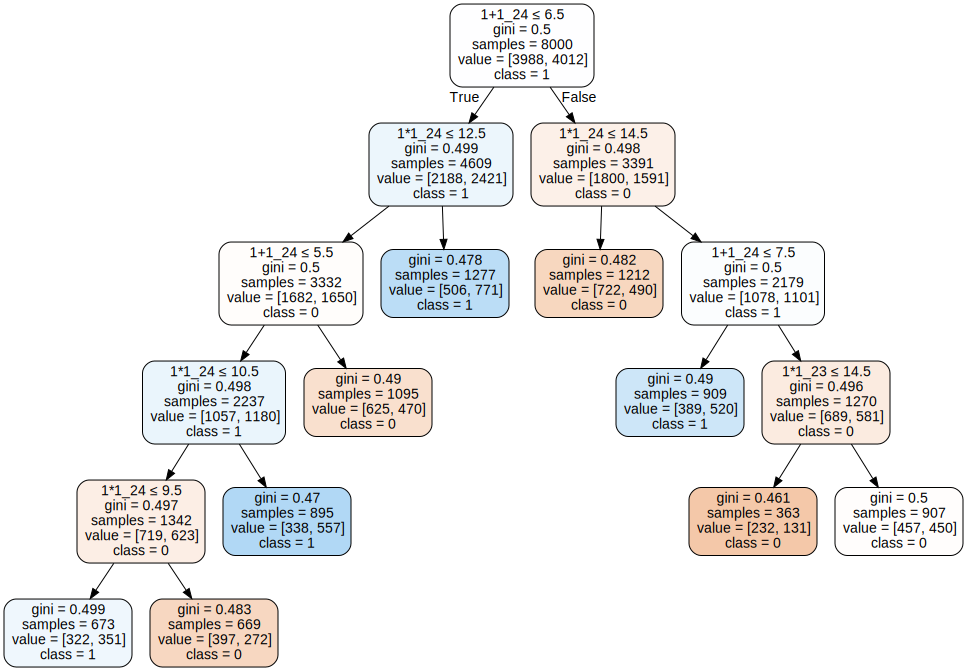

In [77]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(model, feature_names=df.columns[:-1], class_names=['0','1'],
                           filled=True, rounded=True, special_characters=True)
# Draw tree
graph = graphviz.Source(dot_data)
graph.render('Docs/DTree_N_ops_per_row', format='png', cleanup=True)
graph